In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

import torchvision
import torch
from torchvision import transforms
from torchvision import datasets
from torchvision import models
import torch.nn as nn
import torch.nn.functional as F

import time
from torch.utils.tensorboard import SummaryWriter
from ignite.handlers import ModelCheckpoint

from ignite.engine import Engine, Events
from ignite.metrics import Loss, Accuracy
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [2]:
# Cargar Modelo
model = models.resnet18(pretrained=True, progress=True)
for param in model.parameters(): 
    param.requires_grad = False

neurons = model.fc.in_features 
model.fc = torch.nn.Linear(neurons, 4) 

model.load_state_dict(torch.load('./best/ResNet18-Best-47.pt',map_location=torch.device('cpu')))
#display(model)

<All keys matched successfully>

In [3]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor
    
unorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

              precision    recall  f1-score   support

           0       0.89      0.57      0.69        30
           1       0.88      0.70      0.78        30
           2       0.50      0.70      0.58        30
           3       0.60      0.70      0.65        30

    accuracy                           0.67       120
   macro avg       0.72      0.67      0.68       120
weighted avg       0.72      0.67      0.68       120

0.6666666666666666


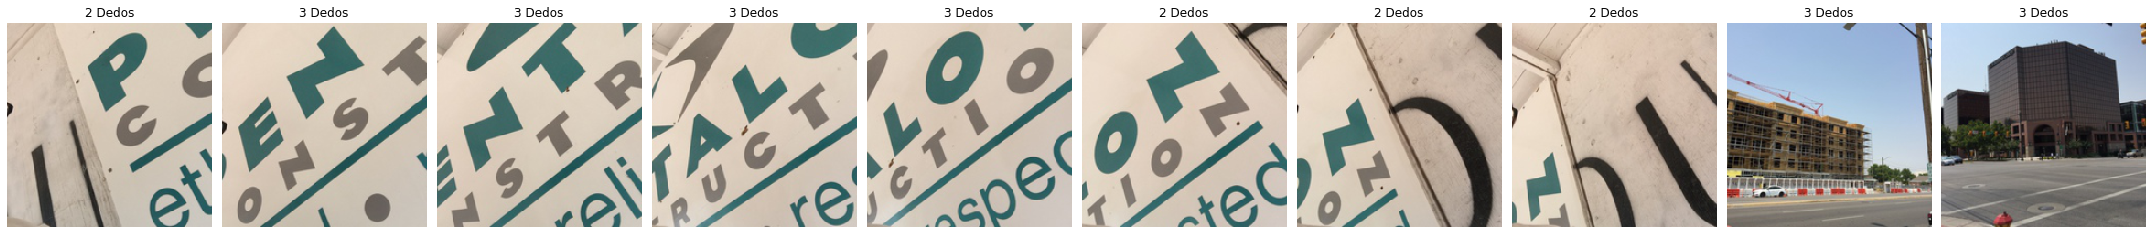

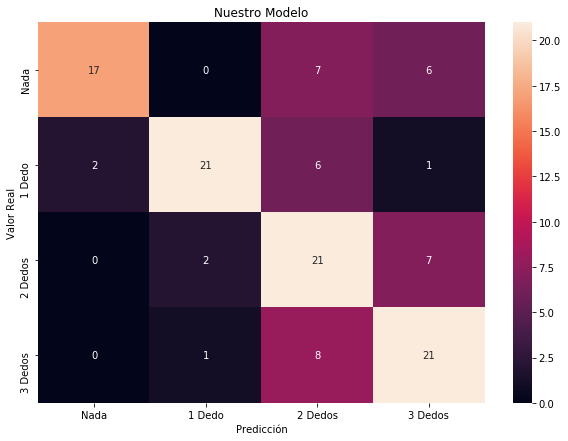

In [4]:
# Evaluar 1 modelo

transform = transforms.Compose([transforms.Resize(224),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406],
                                                      [0.229, 0.224, 0.225])])
   
test_dataset = datasets.ImageFolder('/Users/eduardo/Desktop/Universidad/Sem I 2020/Inteligencia Artificial/Unidad III/Old/gestos/test', transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset,shuffle=False, batch_size=200)


test_targets = test_dataset.targets
prediction_test = []
for mbdata, label in test_loader:
    logits = model.forward(mbdata)
    prediction_test.append(logits.argmax(dim=1).detach().numpy())
    
prediction_test = np.concatenate(prediction_test)

cm = confusion_matrix(test_targets, prediction_test,[0,1,2,3])

# Mal clasificadas
idx = np.where(test_targets != prediction_test)[0]
labs = ["Nada","1 Dedo","2 Dedos","3 Dedos"]
fig, ax = plt.subplots(1, 10, figsize=(30, 20), tight_layout=True)
for i in range(10):
    npimg = unorm(test_dataset[idx[i]][0]).numpy()    
    ax[i].imshow(np.transpose(npimg, (1, 2, 0)))
    ax[i].set_title(labs[prediction_test[idx[i]]])
    ax[i].axis('off')
    
#display(prediction_test)

plt.figure(figsize = (10,7))

ax = plt.subplot()
sn.heatmap(cm, annot=True, ax = ax);

# labels, title and ticks
ax.set_xlabel("Predicción");
ax.set_ylabel("Valor Real"); 

ax.set_title("Nuestro Modelo"); 
ax.xaxis.set_ticklabels(["Nada","1 Dedo","2 Dedos","3 Dedos"]); 
ax.yaxis.set_ticklabels(["Nada","1 Dedo","2 Dedos","3 Dedos"]);

clas = classification_report(test_targets, prediction_test)
print(clas)
print(accuracy_score(test_targets, prediction_test))